![lop](../../images/logo_diive1_128px.png)

<span style='font-size:40px; display:block;'>
<b>
    XGBoost gap-filling
</b>
</span>

---
**Notebook version**: `1` (24 Apr 2024)  
**Author**: Lukas Hörtnagl (holukas@ethz.ch)  

</br>

# **Background**

- Using [XGBoost](https://xgboost.readthedocs.io/en/stable/) to gap-fill time series data

</br>

# **User settings**
`TARGET_COL` ... name of the time series that is gap-filled  
`subsetcols` ... list of columns included in the random forest model, target must also be listed here

All columns that are not the target will be used as features/predictors during model building.

In [8]:
TARGET_COL = 'NEE_CUT_REF_orig'
subsetcols = [TARGET_COL, 'Tair_f', 'VPD_f', 'Rg_f']

</br>

# **Imports**
- This notebook uses `diive` ([source code](https://gitlab.ethz.ch/diive/diive)) to check eddy covariance fluxes for quality

In [9]:
import numpy as np
import importlib.metadata
from datetime import datetime
import matplotlib.pyplot as plt
from diive.configs.exampledata import load_exampledata_parquet
from diive.core.plotting.timeseries import TimeSeries  # For simple (interactive) time series plotting
from diive.core.dfun.stats import sstats  # Time series stats
from diive.core.plotting.heatmap_datetime import HeatmapDateTime
from diive.pkgs.gapfilling.xgboost_ts import XGBoostTS
version_diive = importlib.metadata.version("diive")
print(f"diive version: v{version_diive}")

diive version: v0.75.0


</br>

# **Docstring** for `XGBoostTS`

In [12]:
# help(XGBoostTS)

</br>

---

# **Load data**

## Load example data from parquet file

In [13]:
source_df = load_exampledata_parquet()

Loaded .parquet file F:\Sync\luhk_work\20 - CODING\21 - DIIVE\diive\diive\configs\exampledata\exampledata_PARQUET_CH-DAV_FP2022.5_2013-2022_ID20230206154316_30MIN.parquet (0.483 seconds). Detected time resolution of <30 * Minutes> / 30min 


## Make subset

In [14]:
df = source_df.copy()
lowquality = df["QCF_NEE"] > 0  # This example uses NEE flux data, only records where the quality flag QCF is 0 (highest quality) are retained
df.loc[lowquality, TARGET_COL] = np.nan  # Set fluxes of lower quality to missing
df = df[subsetcols].copy()  # Keep subset columns only

In [15]:
df.describe()

,NEE_CUT_REF_orig,Tair_f,VPD_f,Rg_f
count,41284.000000,175296.000000,175296.000000,175296.000000
mean,-3.833522,4.712999,3.233176,152.671445
std,6.085449,7.548653,3.710180,247.531312
min,-38.653000,-23.096000,0.000000,0.000000
25%,-7.840000,-0.800000,0.661000,0.000000
50%,-3.827000,4.600000,1.991000,2.596000
75%,0.606250,10.067000,4.375000,225.677750
max,25.290000,28.713000,32.118000,1197.800000


In [16]:
sstats(df[TARGET_COL])

,NEE_CUT_REF_orig
STARTDATE,2013-01-01 00:15
ENDDATE,2022-12-31 23:45
PERIOD,3651 days 23:30:00
NOV,41284
MISSING,134012
MISSING_PERC,76.448978
MEAN,-3.833522
SD,6.085449
VAR,37.032694
SD/MEAN,-1.58743


F:\Sync\luhk_work\20 - CODING\21 - DIIVE\diive\diive\core\plotting\timeseries.py:136: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  self.fig.show()


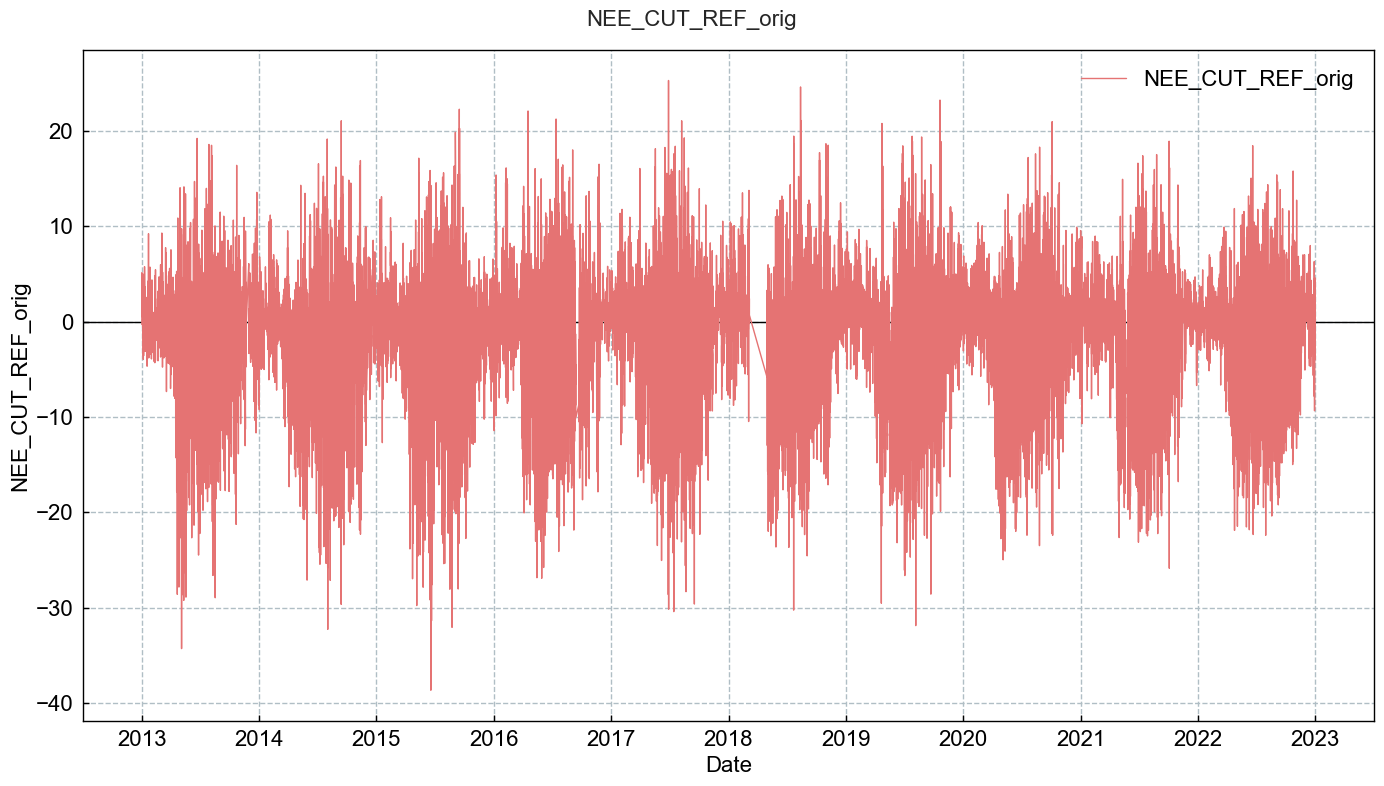

In [17]:
# TimeSeries(series=df[TARGET_COL]).plot_interactive()
TimeSeries(series=df[TARGET_COL]).plot()

</br>

</br>

# **Gap-filling**

## Initialize random forest

In [18]:
xgbts = XGBoostTS(
        input_df=df,
        target_col=TARGET_COL,
        verbose=1,        
        features_lag=[-1, -1],
        include_timestamp_as_features=True,
        add_continuous_record_number=True,
        sanitize_timestamp=True,
        perm_n_repeats=9,
        n_estimators=99,
        random_state=42,
        validate_parameters=True,
        early_stopping_rounds=10,
        max_depth=0,
        learning_rate=0.3,
        tree_method='hist',  # auto, hist, approx, exact
        n_jobs=-1
    )


Creating lagged variants ...
Created lagged variants for: ['Tair_f', 'VPD_f', 'Rg_f'] (lags between -1 and -1 with stepsize 1)
No lagged variants for: ['NEE_CUT_REF_orig']

Adding timestamp as data columns ...
Added timestamp as columns: ['.YEAR', '.SEASON', '.MONTH', '.WEEK', '.DOY', '.HOUR', '.YEARMONTH', '.YEARDOY', '.YEARWEEK'] 

Adding continuous record number ...
Added new column .RECORDNUMBER with record numbers from 1 to 175296.

Sanitizing timestamp ...
Validating timestamp naming of timestamp column TIMESTAMP_MIDDLE ... Timestamp name OK.
Converting timestamp TIMESTAMP_MIDDLE to datetime ... OK
All rows have timestamp TIMESTAMP_MIDDLE, no rows removed.
Sorting timestamp TIMESTAMP_MIDDLE ascending ... Removing data records with duplicate indexes ... OK (no duplicates found in timestamp index)
Creating continuous <30 * Minutes> timestamp index for timestamp TIMESTAMP_MIDDLE between 2013-01-01 00:15:00 and 2022-12-31 23:45:00 ... 

</br>

## Feature reduction

In [20]:
xgbts.reduce_features()



Feature reduction based on permutation importance ...
Fitting model <class 'xgboost.sklearn.XGBRegressor'> ...
[0]	validation_0-rmse:4.60829	validation_1-rmse:4.98506
[1]	validation_0-rmse:3.53554	validation_1-rmse:4.33283
[2]	validation_0-rmse:2.73700	validation_1-rmse:3.94559
[3]	validation_0-rmse:2.13213	validation_1-rmse:3.71711
[4]	validation_0-rmse:1.67054	validation_1-rmse:3.58151
[5]	validation_0-rmse:1.31874	validation_1-rmse:3.50618
[6]	validation_0-rmse:1.04674	validation_1-rmse:3.46122
[7]	validation_0-rmse:0.83428	validation_1-rmse:3.43594
[8]	validation_0-rmse:0.66854	validation_1-rmse:3.42174
[9]	validation_0-rmse:0.53775	validation_1-rmse:3.41309
[10]	validation_0-rmse:0.43413	validation_1-rmse:3.40752
[11]	validation_0-rmse:0.35170	validation_1-rmse:3.40444
[12]	validation_0-rmse:0.28593	validation_1-rmse:3.40189
[13]	validation_0-rmse:0.23310	validation_1-rmse:3.40091
[14]	validation_0-rmse:0.19042	validation_1-rmse:3.39998
[15]	validation_0-rmse:0.15642	validation_

In [21]:
xgbts.report_feature_reduction()


FEATURE REDUCTION

- the random variable .RANDOM was added to the original features, used as benchmark for detecting relevant feature importances
- target variable: NEE_CUT_REF_orig
- features before reduction: ['Rg_f', '.DOY', 'Tair_f', '.Rg_f-1', '.Tair_f-1', '.HOUR', '.VPD_f-1', 'VPD_f', '.WEEK', '.YEARMONTH', '.RECORDNUMBER', '.YEARDOY', '.YEARWEEK', '.YEAR', '.SEASON', '.MONTH', '.RANDOM']
- permutation importance was calculated from 9 permutations
- These results are from feature reduction. Note that feature importances for the final model are calculated during gap-filling.


PERMUTATION IMPORTANCE (FULL RESULTS):

               PERM_IMPORTANCE   PERM_SD
Rg_f                  0.926557  0.009197
.DOY                  0.171640  0.006681
Tair_f                0.118450  0.004091
.Rg_f-1               0.106956  0.001572
.Tair_f-1             0.102180  0.002777
.HOUR                 0.079851  0.002950
.VPD_f-1              0.058664  0.002984
VPD_f                 0.046023  0.001969
.

</br>

## Train model

Building <class 'xgboost.sklearn.XGBRegressor'> model based on data between 2013-01-01 00:15:00 and 2022-12-31 23:45:00 ...
Fitting model <class 'xgboost.sklearn.XGBRegressor'> ...
[0]	validation_0-rmse:4.61965	validation_1-rmse:4.96312
[1]	validation_0-rmse:3.55608	validation_1-rmse:4.28395
[2]	validation_0-rmse:2.76142	validation_1-rmse:3.88127
[3]	validation_0-rmse:2.16038	validation_1-rmse:3.65426
[4]	validation_0-rmse:1.70134	validation_1-rmse:3.51975
[5]	validation_0-rmse:1.34860	validation_1-rmse:3.44594
[6]	validation_0-rmse:1.07414	validation_1-rmse:3.39997
[7]	validation_0-rmse:0.85781	validation_1-rmse:3.37324
[8]	validation_0-rmse:0.68983	validation_1-rmse:3.35977
[9]	validation_0-rmse:0.55647	validation_1-rmse:3.35193
[10]	validation_0-rmse:0.44978	validation_1-rmse:3.34688
[11]	validation_0-rmse:0.36582	validation_1-rmse:3.34462
[12]	validation_0-rmse:0.29840	validation_1-rmse:3.34265
[13]	validation_0-rmse:0.24337	validation_1-rmse:3.34311
[14]	validation_0-rmse:0.19979	

F:\Sync\luhk_work\20 - CODING\21 - DIIVE\diive\diive\core\ml\common.py:595: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


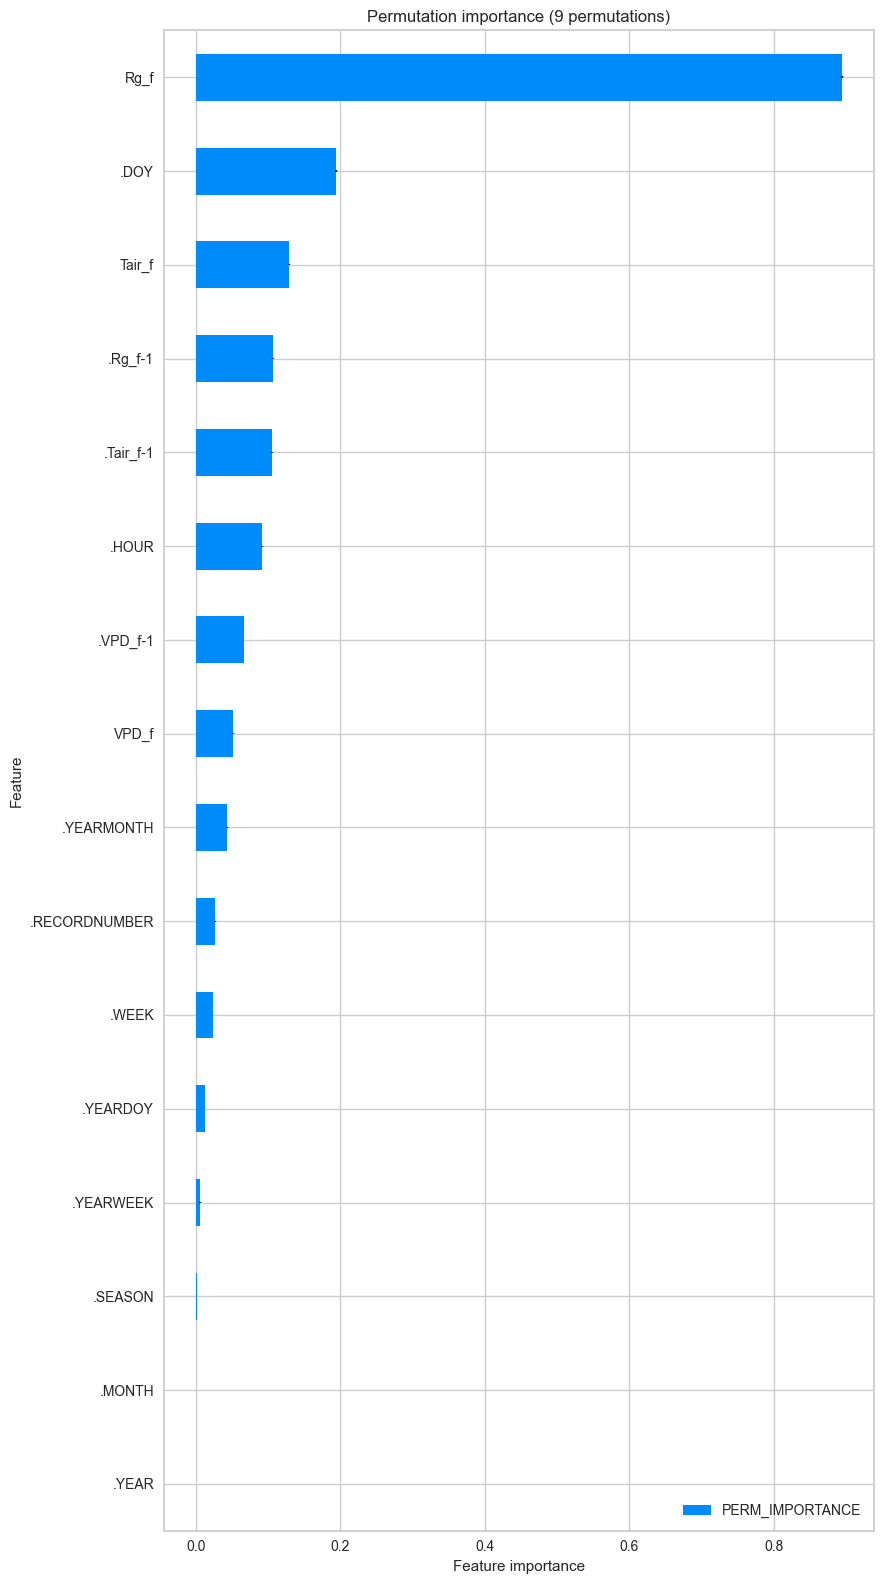

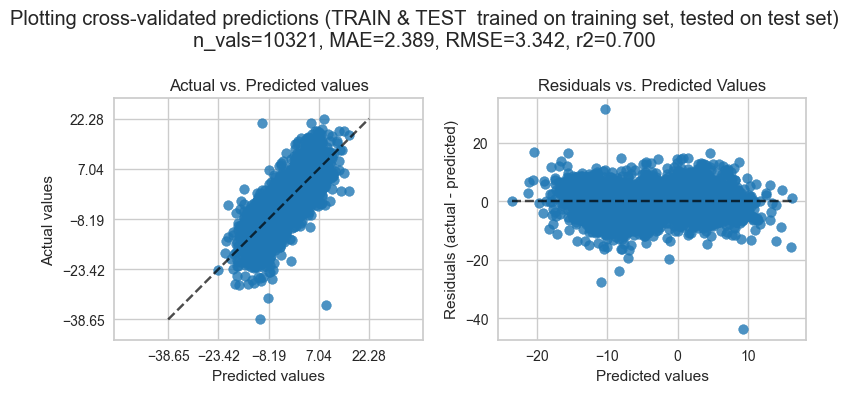

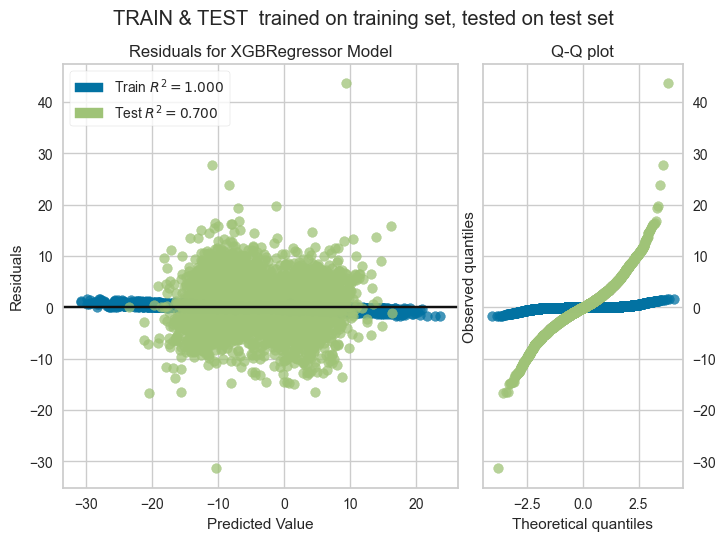

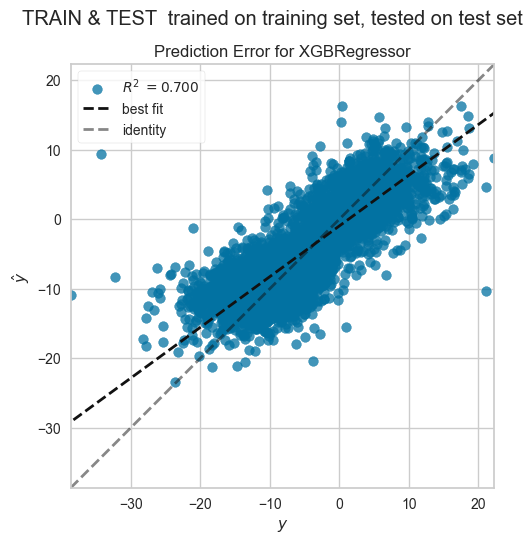

In [23]:
xgbts.trainmodel(showplot_scores=True, showplot_importance=True)

In [24]:
xgbts.report_traintest()


MODEL TRAINING & TESTING RESULTS

- the model was trained and tested based on data between 2013-01-01T01:45:00.000000000 and 2022-12-31T22:15:00.000000000.
- in total, 41284 observed target values were available for training and testing
- the dataset was split into training and test datasets
  > the training dataset comprised 30963 target values (75.0%)
  > the test dataset comprised 10321 target values (25.0%)

## FEATURE IMPORTANCES
- feature importances were calculated for test data (10321 target values).
- permutation importances were calculated from 9 repeats.
               PERM_IMPORTANCE   PERM_SD
Rg_f                  0.894080  0.012196
.DOY                  0.193860  0.007116
Tair_f                0.128585  0.004280
.Rg_f-1               0.106424  0.002401
.Tair_f-1             0.105614  0.002766
.HOUR                 0.090925  0.004901
.VPD_f-1              0.066292  0.003484
VPD_f                 0.051065  0.002615
.YEARMONTH            0.042469  0.001768
.RECORDNUMBER    

</br>

## Apply model to fill gaps

Calculating permutation importance using model <class 'xgboost.sklearn.XGBRegressor'> ...


F:\Sync\luhk_work\20 - CODING\21 - DIIVE\diive\diive\core\ml\common.py:595: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


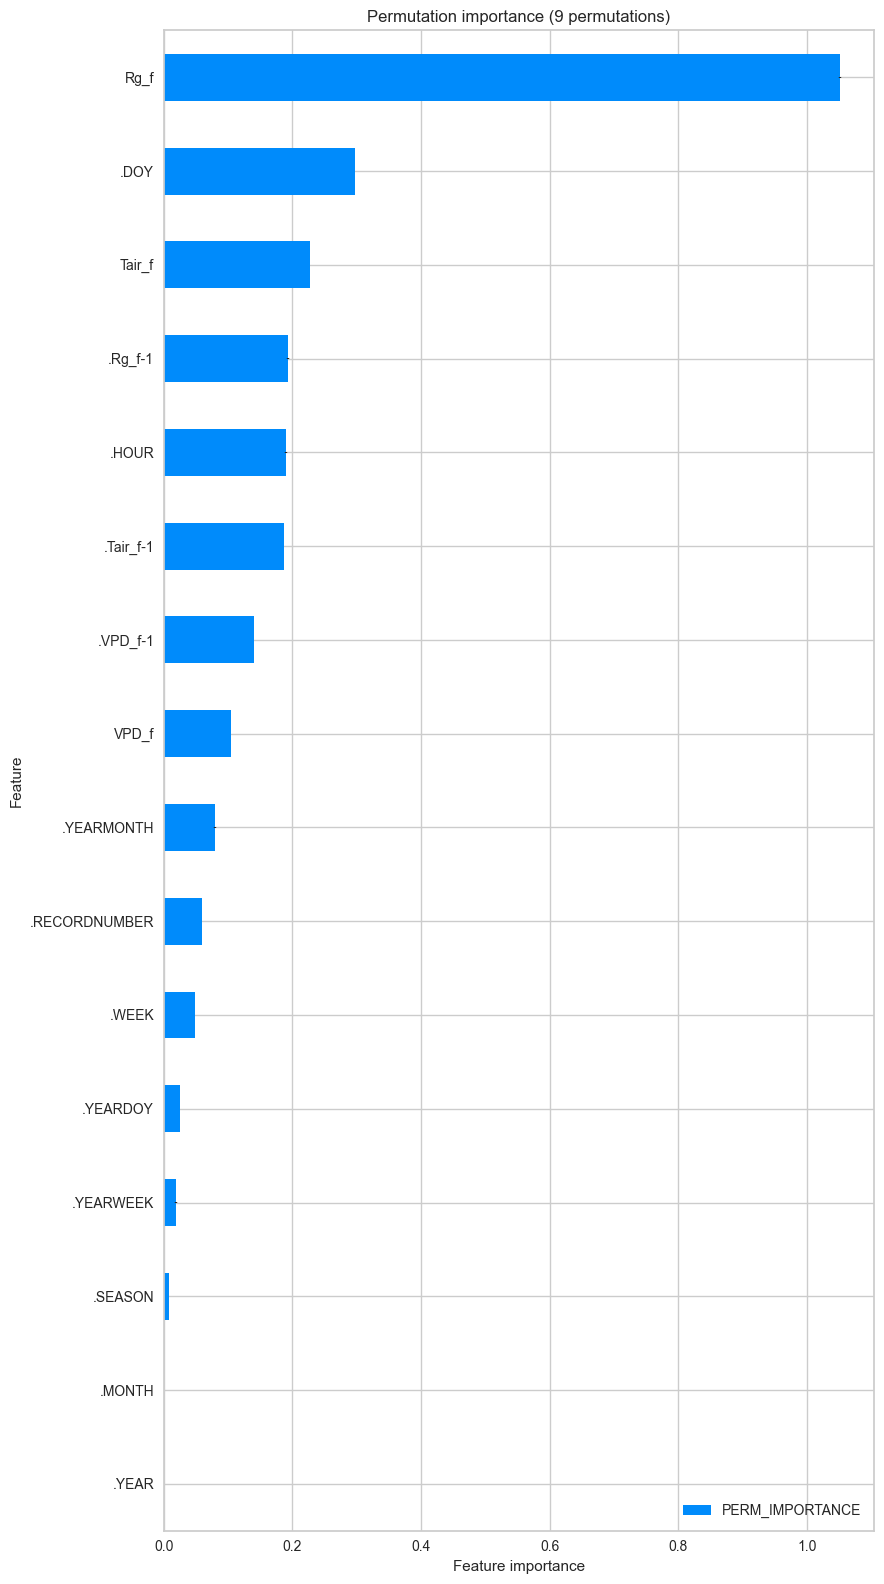

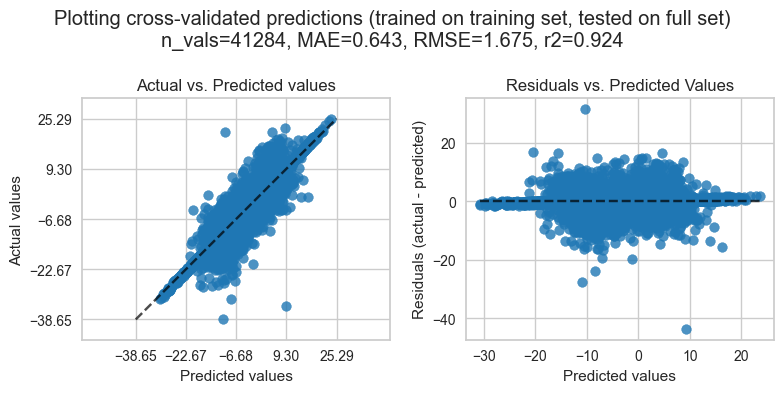


Adding timestamp as data columns ...
Added timestamp as columns: ['.YEAR', '.SEASON', '.MONTH', '.WEEK', '.DOY', '.HOUR', '.YEARMONTH', '.YEARDOY', '.YEARWEEK'] (ONLY FALLBACK)
Fitting model <class 'xgboost.sklearn.XGBRegressor'> ...
[0]	validation_0-rmse:3.83081	validation_1-rmse:3.83081
[1]	validation_0-rmse:3.07189	validation_1-rmse:3.07189
[2]	validation_0-rmse:2.56924	validation_1-rmse:2.56924
[3]	validation_0-rmse:2.23805	validation_1-rmse:2.23805
[4]	validation_0-rmse:2.02226	validation_1-rmse:2.02226
[5]	validation_0-rmse:1.88223	validation_1-rmse:1.88223
[6]	validation_0-rmse:1.79301	validation_1-rmse:1.79301
[7]	validation_0-rmse:1.73575	validation_1-rmse:1.73575
[8]	validation_0-rmse:1.69920	validation_1-rmse:1.69920
[9]	validation_0-rmse:1.67628	validation_1-rmse:1.67628
[10]	validation_0-rmse:1.66181	validation_1-rmse:1.66181
[11]	validation_0-rmse:1.65261	validation_1-rmse:1.65261
[12]	validation_0-rmse:1.64677	validation_1-rmse:1.64677
[13]	validation_0-rmse:1.64306	val

In [25]:
xgbts.fillgaps(showplot_scores=True, showplot_importance=True)

In [26]:
xgbts.report_gapfilling()


GAP-FILLING RESULTS

Model scores and feature importances were calculated from high-quality predicted targets (134011 values, NEE_CUT_REF_orig_gfRF where flag=1) in comparison to observed targets (41284 values, NEE_CUT_REF_orig).

## TARGET
- first timestamp:  2013-01-01 00:15:00
- last timestamp:  2022-12-31 23:45:00
- potential number of values: 175296 values)
- target column (observed):  NEE_CUT_REF_orig
- missing records (observed):  134012 (cross-check from flag: 134012)
- target column (gap-filled):  NEE_CUT_REF_orig_gfRF  (175296 values)
- missing records (gap-filled):  0
- gap-filling flag: FLAG_NEE_CUT_REF_orig_gfRF_ISFILLED
  > flag 0 ... observed targets (41284 values)
  > flag 1 ... targets gap-filled with high-quality, all features available (134011 values)
  > flag 2 ... targets gap-filled with fallback (1 values)

## FEATURE IMPORTANCES
- names of features used in model:  ['Rg_f', '.DOY', 'Tair_f', '.Rg_f-1', '.HOUR', '.Tair_f-1', '.VPD_f-1', 'VPD_f', '.YEARMONTH', '.RE

</br>

## Attributes
A lot more information about feature reduction, training and testing, model building and gap-filling is available via the class attributes.

In [27]:
xgbts.feature_importances_

,PERM_IMPORTANCE,PERM_SD
Rg_f,1.051350,0.004352
.DOY,0.296587,0.002639
Tair_f,0.227427,0.001968
.Rg_f-1,0.193330,0.002117
.HOUR,0.190701,0.002925
.Tair_f-1,0.186915,0.001672
.VPD_f-1,0.140234,0.001066
VPD_f,0.105163,0.001561
.YEARMONTH,0.079876,0.001374
.RECORDNUMBER,0.059402,0.001180


In [28]:
xgbts.feature_importances_reduction_

,PERM_IMPORTANCE,PERM_SD
Rg_f,0.926557,0.009197
.DOY,0.171640,0.006681
Tair_f,0.118450,0.004091
.Rg_f-1,0.106956,0.001572
.Tair_f-1,0.102180,0.002777
.HOUR,0.079851,0.002950
.VPD_f-1,0.058664,0.002984
VPD_f,0.046023,0.001969
.WEEK,0.032746,0.001603
.YEARMONTH,0.029165,0.001746


In [29]:
xgbts.feature_importances_traintest_

,PERM_IMPORTANCE,PERM_SD
Rg_f,0.894080,0.012196
.DOY,0.193860,0.007116
Tair_f,0.128585,0.004280
.Rg_f-1,0.106424,0.002401
.Tair_f-1,0.105614,0.002766
.HOUR,0.090925,0.004901
.VPD_f-1,0.066292,0.003484
VPD_f,0.051065,0.002615
.YEARMONTH,0.042469,0.001768
.RECORDNUMBER,0.026220,0.003046


In [30]:
xgbts.gapfilling_df_

,.PREDICTIONS_FULLMODEL,NEE_CUT_REF_orig,.GAP_PREDICTIONS,FLAG_NEE_CUT_REF_orig_gfRF_ISFILLED,NEE_CUT_REF_orig_gfRF,.PREDICTIONS_FALLBACK,.GAPFILLED_CUMULATIVE,.PREDICTIONS
TIMESTAMP_MIDDLE,,,,,,,,
2013-01-01 00:15:00,NaN,NaN,NaN,2.0,0.408063,0.408063,0.408063,0.408063
2013-01-01 00:45:00,0.465840,NaN,0.465840,1.0,0.465840,0.408063,0.873904,0.465840
2013-01-01 01:15:00,0.506889,NaN,0.506889,1.0,0.506889,0.465039,1.380792,0.506889
2013-01-01 01:45:00,0.506889,0.538,NaN,0.0,0.538000,0.465039,1.918792,0.506889
2013-01-01 02:15:00,-0.770389,NaN,-0.770389,1.0,-0.770389,-0.182867,1.148403,-0.770389
...,...,...,...,...,...,...,...,...
2022-12-31 21:45:00,3.145056,NaN,3.145056,1.0,3.145056,1.902051,-84345.272093,3.145056
2022-12-31 22:15:00,3.459471,3.518,NaN,0.0,3.518000,0.029508,-84341.754093,3.459471
2022-12-31 22:45:00,0.731468,NaN,0.731468,1.0,0.731468,0.029508,-84341.022625,0.731468


In [31]:
xgbts.model_

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.3, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=0, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=99, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [32]:
xgbts.accepted_features_

['Rg_f',
 '.DOY',
 'Tair_f',
 '.Rg_f-1',
 '.Tair_f-1',
 '.HOUR',
 '.VPD_f-1',
 'VPD_f',
 '.WEEK',
 '.YEARMONTH',
 '.RECORDNUMBER',
 '.YEARDOY',
 '.YEARWEEK',
 '.YEAR',
 '.SEASON',
 '.MONTH']

In [33]:
xgbts.rejected_features_

['.RANDOM']

In [34]:
xgbts.scores_

{'mae': 0.6433955496379932,
 'medae': 0.04152118301391594,
 'mse': 2.806024830856196,
 'rmse': 1.6751193482424458,
 'mape': 454184803030.9276,
 'maxe': 43.60479725646972,
 'r2': 0.9242266093511264}

In [35]:
xgbts.scores_test_

{'mae': 2.3892699219244062,
 'medae': 1.7392821270227432,
 'mse': 11.16938961191176,
 'rmse': 3.3420636756219593,
 'mape': 1804039429363.9695,
 'maxe': 43.60479725646972,
 'r2': 0.700166522664261}

In [36]:
xgbts.traintest_details_.keys()

dict_keys(['X', 'y', 'timestamp', 'predictions', 'X_names', 'y_name', 'X_train', 'y_train', 'X_test', 'y_test', 'model'])

</br>

## Result

In [37]:
gapfilled = xgbts.get_gapfilled_target()
gapfilled

TIMESTAMP_MIDDLE
2013-01-01 00:15:00    0.408063
2013-01-01 00:45:00    0.465840
2013-01-01 01:15:00    0.506889
2013-01-01 01:45:00    0.538000
2013-01-01 02:15:00   -0.770389
                         ...   
2022-12-31 21:45:00    3.145056
2022-12-31 22:15:00    3.518000
2022-12-31 22:45:00    0.731468
2022-12-31 23:15:00    0.780104
2022-12-31 23:45:00    0.088840
Freq: 30min, Name: NEE_CUT_REF_orig_gfRF, Length: 175296, dtype: float64

In [38]:
flag = xgbts.get_flag()
flag

TIMESTAMP_MIDDLE
2013-01-01 00:15:00    2.0
2013-01-01 00:45:00    1.0
2013-01-01 01:15:00    1.0
2013-01-01 01:45:00    0.0
2013-01-01 02:15:00    1.0
                      ... 
2022-12-31 21:45:00    1.0
2022-12-31 22:15:00    0.0
2022-12-31 22:45:00    1.0
2022-12-31 23:15:00    1.0
2022-12-31 23:45:00    1.0
Freq: 30min, Name: FLAG_NEE_CUT_REF_orig_gfRF_ISFILLED, Length: 175296, dtype: float64

In [39]:
gapfilling_df = xgbts.gapfilling_df_
gapfilling_df

,.PREDICTIONS_FULLMODEL,NEE_CUT_REF_orig,.GAP_PREDICTIONS,FLAG_NEE_CUT_REF_orig_gfRF_ISFILLED,NEE_CUT_REF_orig_gfRF,.PREDICTIONS_FALLBACK,.GAPFILLED_CUMULATIVE,.PREDICTIONS
TIMESTAMP_MIDDLE,,,,,,,,
2013-01-01 00:15:00,NaN,NaN,NaN,2.0,0.408063,0.408063,0.408063,0.408063
2013-01-01 00:45:00,0.465840,NaN,0.465840,1.0,0.465840,0.408063,0.873904,0.465840
2013-01-01 01:15:00,0.506889,NaN,0.506889,1.0,0.506889,0.465039,1.380792,0.506889
2013-01-01 01:45:00,0.506889,0.538,NaN,0.0,0.538000,0.465039,1.918792,0.506889
2013-01-01 02:15:00,-0.770389,NaN,-0.770389,1.0,-0.770389,-0.182867,1.148403,-0.770389
...,...,...,...,...,...,...,...,...
2022-12-31 21:45:00,3.145056,NaN,3.145056,1.0,3.145056,1.902051,-84345.272093,3.145056
2022-12-31 22:15:00,3.459471,3.518,NaN,0.0,3.518000,0.029508,-84341.754093,3.459471
2022-12-31 22:45:00,0.731468,NaN,0.731468,1.0,0.731468,0.029508,-84341.022625,0.731468


</br>

## Plot

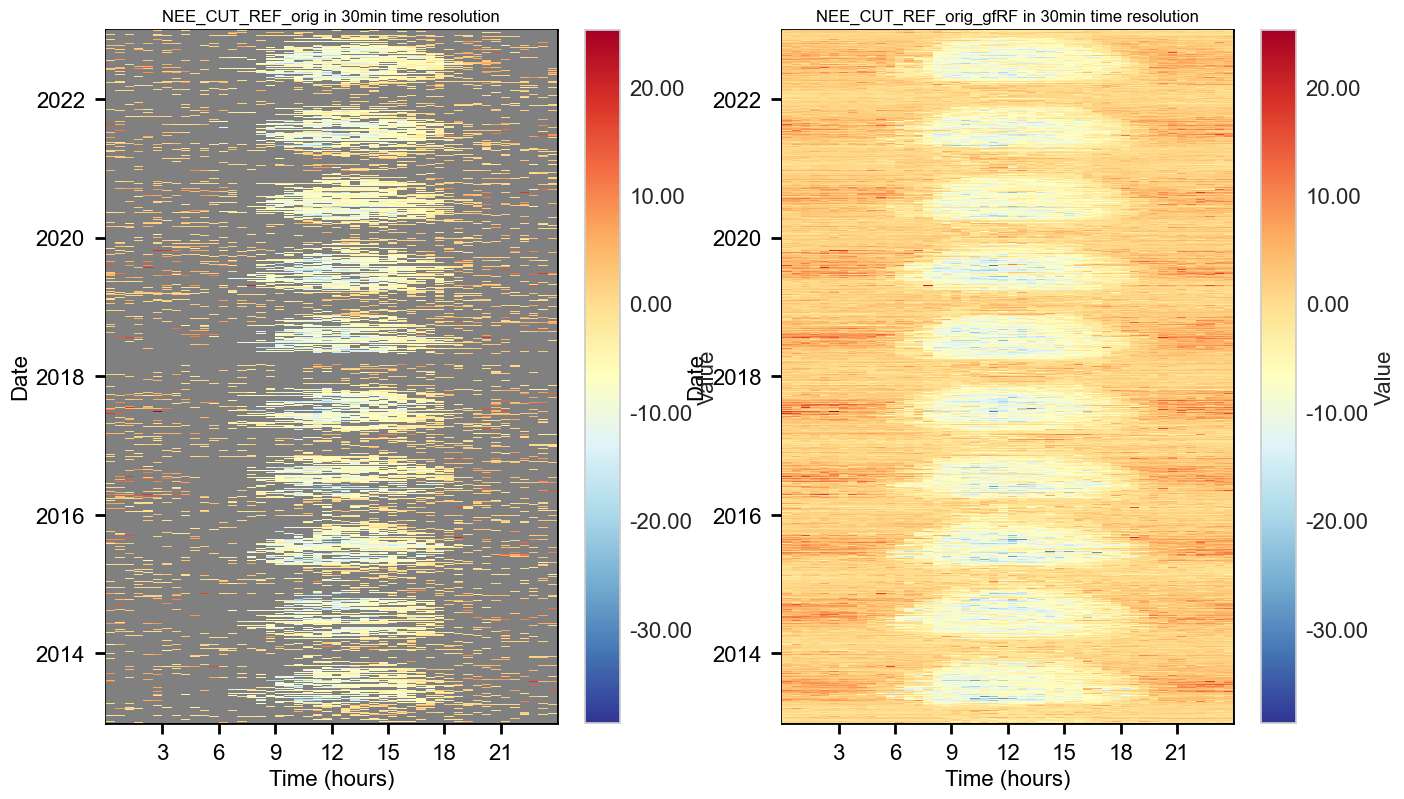

In [40]:
fig, axs = plt.subplots(ncols=2, figsize=(16, 9))
HeatmapDateTime(series=df[TARGET_COL], ax=axs[0]).plot()
HeatmapDateTime(series=gapfilled, ax=axs[1]).plot()

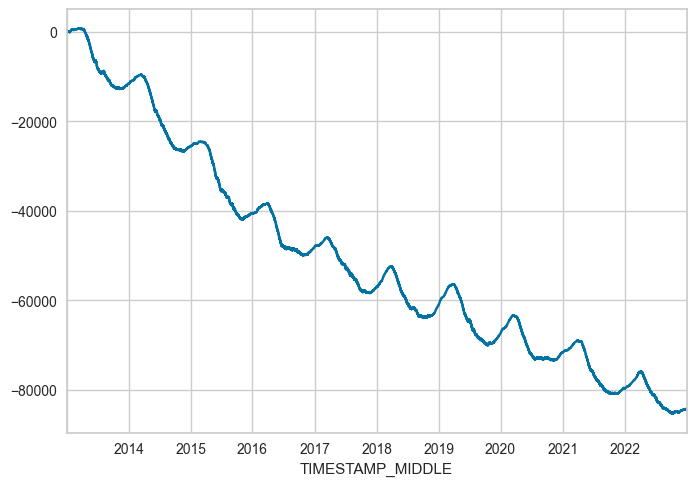

In [41]:
gapfilled.cumsum().plot();

</br>

# **End of notebook**
Congratulations, you reached the end of this notebook! Before you go let's store your finish time.

In [42]:
dt_string = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Finished. {dt_string}")

Finished. 2024-04-24 19:59:31
